# Classification with MIL

In this tutorial, we demonstrate how to train MultiMIL's MIL classification module on the latent representation of an already integrated dataset. We will use a subset of the human lung cell atlas (HLCA) {cite:p}`Sikkema2023-oh`.

In [1]:
import sys

# if branch is stable, will install via pypi, else will install from source
branch = "latest"
IN_COLAB = "google.colab" in sys.modules

if IN_COLAB and branch == "stable":
    !pip install multimil
elif IN_COLAB and branch != "stable":
    !pip install --quiet --upgrade jsonschema
    !pip install git+https://github.com/theislab/multimil

In [2]:
import anndata as ad
import multimil as mtm
import numpy as np
import scanpy as sc
import warnings

warnings.filterwarnings("ignore")

[rank: 0] Global seed set to 0


## Data loading

We provide a subset of the HLCA containing healthy and idiopathic pulmonary fibrosis (IPF) samples, additionally subset to 100,000 to speed up the training. The data already contains the latent representations from the atlas.

In [3]:
data_path = "hlca_tutorial.h5ad"

In [4]:
try:
    adata = sc.read_h5ad(data_path)
except OSError:
    import gdown

    gdown.download("https://drive.google.com/uc?export=download&id=1wWGwbPeap-IqWNVlwVVUWVrUAMrf45ye")
    adata = sc.read_h5ad(data_path)

adata

AnnData object with n_obs × n_vars = 450214 × 30
    obs: "3'_or_5'", 'BMI', 'age_or_mean_of_age_range', 'age_range', 'anatomical_region_ccf_score', 'ancestry', 'assay', 'cause_of_death', 'cell_type', 'core_or_extension', 'dataset', 'development_stage', 'disease', 'donor_id', 'fresh_or_frozen', 'log10_total_counts', 'lung_condition', 'mixed_ancestry', 'sample', 'scanvi_label', 'sequencing_platform', 'sex', 'smoking_status', 'study', 'subject_type', 'suspension_type', 'tissue', 'tissue_coarse_unharmonized', 'tissue_detailed_unharmonized', 'tissue_dissociation_protocol', 'tissue_level_2', 'tissue_level_3', 'tissue_sampling_method', 'total_counts', 'ann_level_1_label_final', 'ann_level_2_label_final', 'ann_level_3_label_final', 'ann_level_4_label_final', 'ann_level_5_label_final'
    obsm: 'X_umap'

## Data preparation

We split the samples into reference (80%) and query (20%) samples.

In [5]:
sample_key = "sample"

In [6]:
samples = np.unique(adata.obs[sample_key])
n_samples = len(samples)
query_proportion = 0.2

In [7]:
rng = np.random.default_rng(0)
query_samples = rng.choice(samples, int(n_samples * query_proportion), replace=False)

In [8]:
query = adata[adata.obs[sample_key].isin(query_samples)].copy()
adata = adata[~adata.obs[sample_key].isin(query_samples)].copy()

query.obs["ref"] = "query"
adata.obs["ref"] = "reference"

In [9]:
query

AnnData object with n_obs × n_vars = 90619 × 30
    obs: "3'_or_5'", 'BMI', 'age_or_mean_of_age_range', 'age_range', 'anatomical_region_ccf_score', 'ancestry', 'assay', 'cause_of_death', 'cell_type', 'core_or_extension', 'dataset', 'development_stage', 'disease', 'donor_id', 'fresh_or_frozen', 'log10_total_counts', 'lung_condition', 'mixed_ancestry', 'sample', 'scanvi_label', 'sequencing_platform', 'sex', 'smoking_status', 'study', 'subject_type', 'suspension_type', 'tissue', 'tissue_coarse_unharmonized', 'tissue_detailed_unharmonized', 'tissue_dissociation_protocol', 'tissue_level_2', 'tissue_level_3', 'tissue_sampling_method', 'total_counts', 'ann_level_1_label_final', 'ann_level_2_label_final', 'ann_level_3_label_final', 'ann_level_4_label_final', 'ann_level_5_label_final', 'ref'
    obsm: 'X_umap'

## Data setup

We need to specify which covariate will be our prediction covariate, so in this case it is `disease` that contains information whether each sample is a healthy or an IPF sample. The sample key is needed so the model knows which cells come from which sample.

In [10]:
classification_keys = ["disease"]
z_dim = 30
categorical_covariate_keys = classification_keys + [sample_key]

For the training to work properly, we need to sort the data by samples.

In [11]:
idx = adata.obs[sample_key].sort_values().index
adata = adata[idx].copy()

idx = query.obs[sample_key].sort_values().index
query = query[idx].copy()

In [12]:
mtm.model.MILClassifier.setup_anndata(
    adata,
    categorical_covariate_keys=categorical_covariate_keys,
)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


## Model setup and training

Next, we initialize the model. We need to specify the prediction covariate, the dimensionality of the latent space and the sample key.  The prediction covariate and the sample key have to be registered covariates that we passed to `setup_anndata()` in the previous step. It is also possible to have ordinal regression or regression as the prediction task. Please refer to the API for more details. We set the coeficient for the classification loss here to 0.1. This parameter might require some fine-tuning depending on the dataset.

In [13]:
mil = mtm.model.MILClassifier(
    adata,
    classification=classification_keys,
    z_dim=z_dim,
    sample_key=sample_key,
    class_loss_coef=0.1,
)

In [14]:
mil.train(lr=1e-3)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 52/200:  26%|██▌       | 52/200 [08:29<24:09,  9.79s/it, loss=2.98e-09, v_num=1]
Monitored metric accuracy_validation did not improve in the last 50 records. Best score: 1.000. Signaling Trainer to stop.


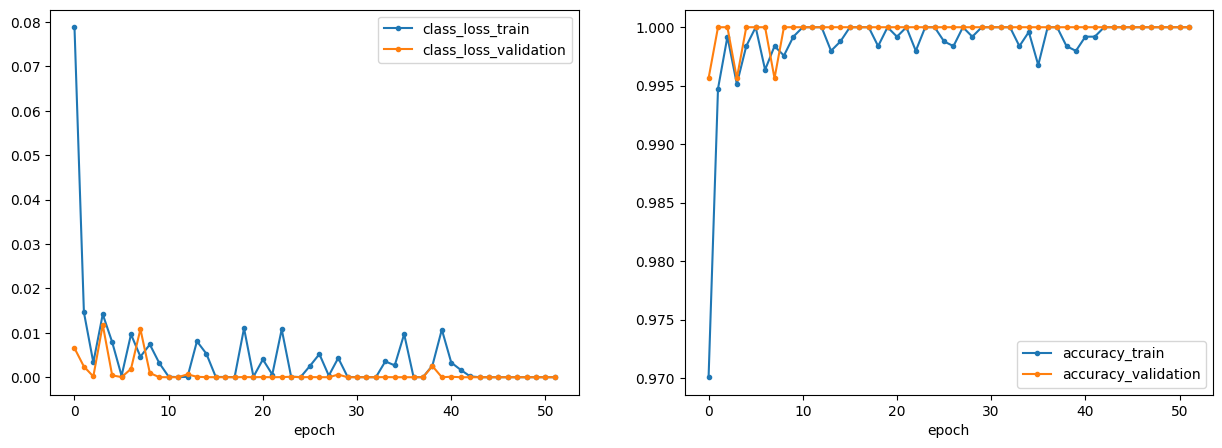

In [15]:
mil.plot_losses()

## Visualizing the attention scores

Next, we obtained the leanred attention scores and visualize them. The attention scores are saved to `.obs['cell_attn']`.

In [16]:
mil.get_model_output()
adata

AnnData object with n_obs × n_vars = 359595 × 30
    obs: "3'_or_5'", 'BMI', 'age_or_mean_of_age_range', 'age_range', 'anatomical_region_ccf_score', 'ancestry', 'assay', 'cause_of_death', 'cell_type', 'core_or_extension', 'dataset', 'development_stage', 'disease', 'donor_id', 'fresh_or_frozen', 'log10_total_counts', 'lung_condition', 'mixed_ancestry', 'sample', 'scanvi_label', 'sequencing_platform', 'sex', 'smoking_status', 'study', 'subject_type', 'suspension_type', 'tissue', 'tissue_coarse_unharmonized', 'tissue_detailed_unharmonized', 'tissue_dissociation_protocol', 'tissue_level_2', 'tissue_level_3', 'tissue_sampling_method', 'total_counts', 'ann_level_1_label_final', 'ann_level_2_label_final', 'ann_level_3_label_final', 'ann_level_4_label_final', 'ann_level_5_label_final', 'ref', '_scvi_batch', 'cell_attn', 'bags', 'predicted_disease'
    uns: '_scvi_uuid', '_scvi_manager_uuid', 'bag_true_disease', 'bag_full_predictions_disease'
    obsm: 'X_umap', '_scvi_extra_categorical_covs', 

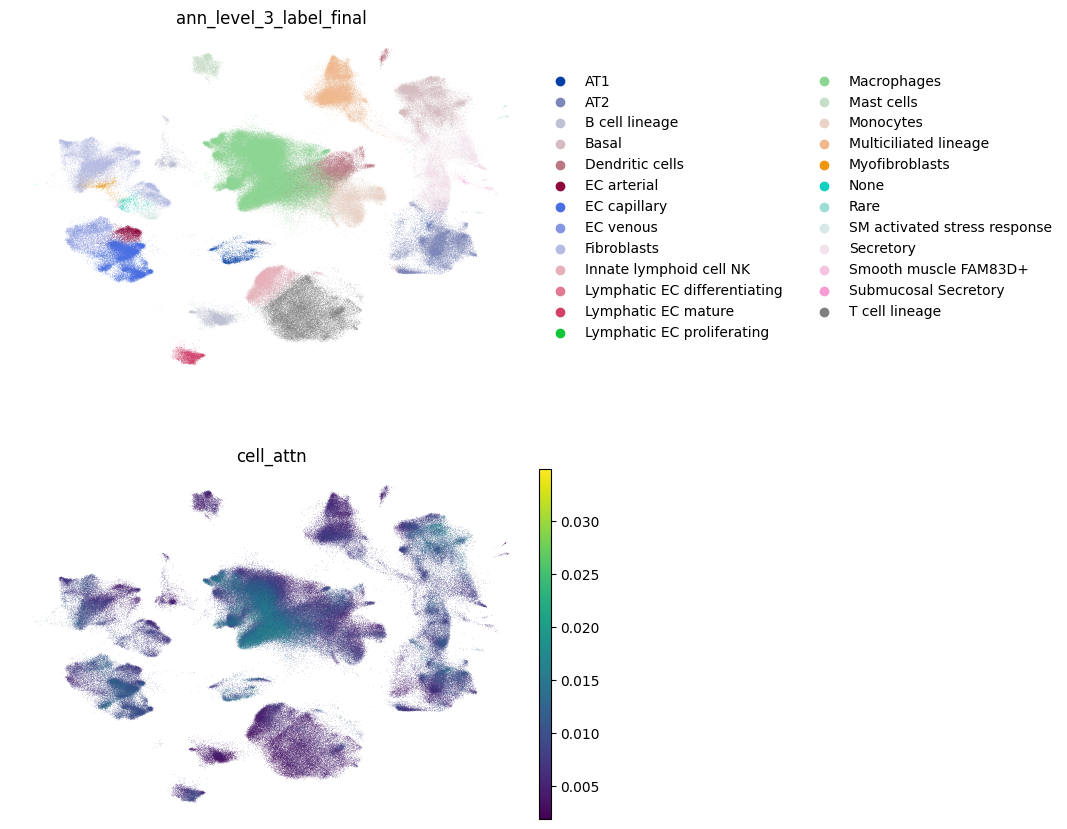

In [17]:
sc.pl.umap(adata, color=["ann_level_3_label_final", "cell_attn"], ncols=1, frameon=False)

In [18]:
new_model = mtm.model.MILClassifier.load_query_data(query, mil)

In [19]:
new_model.get_model_output()
query

AnnData object with n_obs × n_vars = 90619 × 30
    obs: "3'_or_5'", 'BMI', 'age_or_mean_of_age_range', 'age_range', 'anatomical_region_ccf_score', 'ancestry', 'assay', 'cause_of_death', 'cell_type', 'core_or_extension', 'dataset', 'development_stage', 'disease', 'donor_id', 'fresh_or_frozen', 'log10_total_counts', 'lung_condition', 'mixed_ancestry', 'sample', 'scanvi_label', 'sequencing_platform', 'sex', 'smoking_status', 'study', 'subject_type', 'suspension_type', 'tissue', 'tissue_coarse_unharmonized', 'tissue_detailed_unharmonized', 'tissue_dissociation_protocol', 'tissue_level_2', 'tissue_level_3', 'tissue_sampling_method', 'total_counts', 'ann_level_1_label_final', 'ann_level_2_label_final', 'ann_level_3_label_final', 'ann_level_4_label_final', 'ann_level_5_label_final', 'ref', '_scvi_batch', 'cell_attn', 'bags', 'predicted_disease'
    uns: '_scvi_uuid', '_scvi_manager_uuid', 'bag_true_disease', 'bag_full_predictions_disease'
    obsm: 'X_umap', '_scvi_extra_categorical_covs', '

In [20]:
adata_both = ad.concat([adata, query])

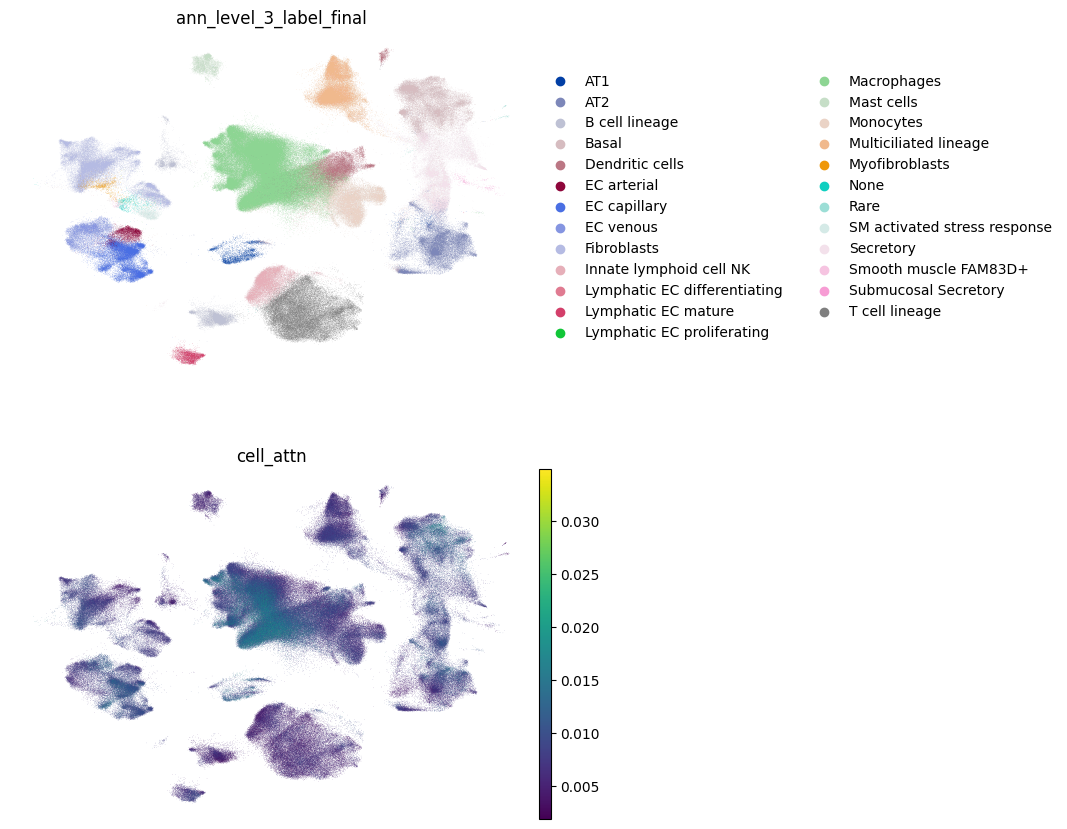

In [21]:
sc.pl.umap(adata_both, color=["ann_level_3_label_final", "cell_attn"], ncols=1, frameon=False)

Finally, let's calcultae the predictino accuracy for the query samples.

In [22]:
from sklearn.metrics import classification_report

print(classification_report(query.obs["disease"], query.obs["predicted_disease"]))

                    precision    recall  f1-score   support

            normal       1.00      0.02      0.03     28254
pulmonary fibrosis       0.69      1.00      0.82     62365

          accuracy                           0.69     90619
         macro avg       0.85      0.51      0.43     90619
      weighted avg       0.79      0.69      0.57     90619

